Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [95]:
import os, shutil, pathlib
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential #type: ignore
from keras.callbacks import EarlyStopping #type: ignore
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization #type: ignore
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Battery","Glass","Metal","Organic","Paper","Plastic"]

base_dir = pathlib.Path("ImagenesOrdenadas")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")


Found 3252 files belonging to 6 classes.
Found 696 files belonging to 6 classes.
Found 702 files belonging to 6 classes.


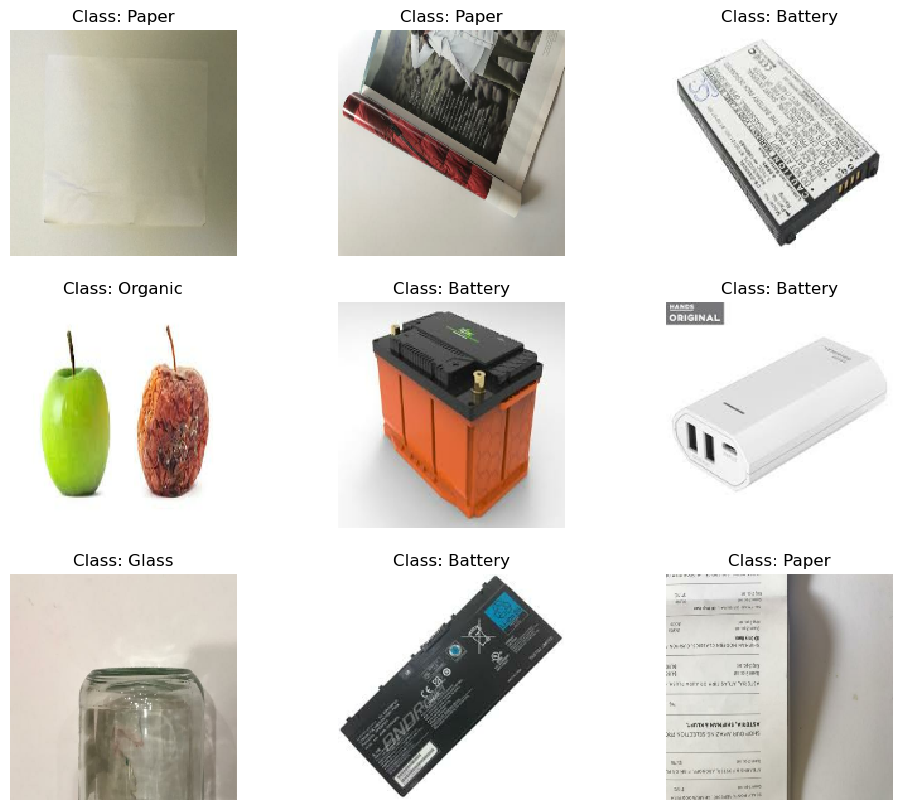

In [96]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Se inicializa el modelo YA NO SE PUEDE pero sin la capa de arriba, ya que nosotros queremos indicarle que clases son las que el modelo debe manejar para hacer las predicciones

In [97]:
def create_custom_cnn(input_shape=(180, 180, 3), num_classes=6):
    model = Sequential()

    # Primera capa convolucional
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Tercera capa convolucional
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    # Aplanamiento de las características
    model.add(Flatten())

    # Capa completamente conectada
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    return model

model_final = create_custom_cnn(input_shape=(180, 180, 3), num_classes=6)
model_final.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,646 (25.36 MB)

 Trainable params: 6,648,198 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [98]:
model_final.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

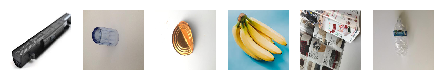

In [99]:
battery = keras.utils.load_img('ImagenesOrdenadas/test/battery/battery5.jpg', target_size=(180,180))
glass = keras.utils.load_img('ImagenesOrdenadas/test/glass/glass3.jpg', target_size=(180,180))
metal= keras.utils.load_img('ImagenesOrdenadas/test/metal/metal2.jpg', target_size=(180,180))
organic= keras.utils.load_img('ImagenesOrdenadas/test/organic/biological1.jpg', target_size=(180,180))
paper= keras.utils.load_img('ImagenesOrdenadas/test/paper/paper14.jpg', target_size=(180,180))
plastic= keras.utils.load_img('ImagenesOrdenadas/test/plastic/plastic5.jpg', target_size=(180,180))


battery_array = np.array(battery)
glass_array = np.array(glass)
metal_array = np.array(metal)
organic_array = np.array(organic)
paper_array = np.array(paper)
plastic_array = np.array(plastic)

images = np.array([battery_array, glass_array,metal_array,organic_array,paper_array,plastic_array])

plt.subplot(171)
plt.imshow(images[0]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(172)
plt.imshow(images[1]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(173)
plt.imshow(images[2]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(174)
plt.imshow(images[3]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(175)
plt.imshow(images[4]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(176)
plt.imshow(images[5]/255, interpolation="nearest")
plt.axis("off")
plt.show()

In [100]:
# Configurar el callback EarlyStopping
early_stopper = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del mejor modelo al final del entrenamiento
)

# Entrenar el modelo
history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,# Ajusta el número de épocas según sea necesario
    callbacks=[early_stopper]
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 648ms/step - accuracy: 0.4072 - loss: 8.8430 - val_accuracy: 0.2428 - val_loss: 8.6881
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 70s 683ms/step - accuracy: 0.4068 - loss: 1.8349 - val_accuracy: 0.3491 - val_loss: 5.7883
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 699ms/step - accuracy: 0.4382 - loss: 1.7598 - val_accuracy: 0.4468 - val_loss: 4.0552
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 708ms/step - accuracy: 0.4390 - loss: 1.4733 - val_accuracy: 0.4095 - val_loss: 4.2532
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 799ms/step - accuracy: 0.4405 - loss: 1.4578 - val_accuracy: 0.4468 - val_loss: 1.3806
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 84s 820ms/step - accuracy: 0.4833 - loss: 1.3346 - val_accuracy: 0.5172 - val_loss: 1.4463
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 807ms/step - accuracy: 0.4787 - loss: 1.3145 - val_accuracy: 0.4353 - val_loss: 1.6429
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 785ms/step - accuracy: 0.5042 - loss: 1

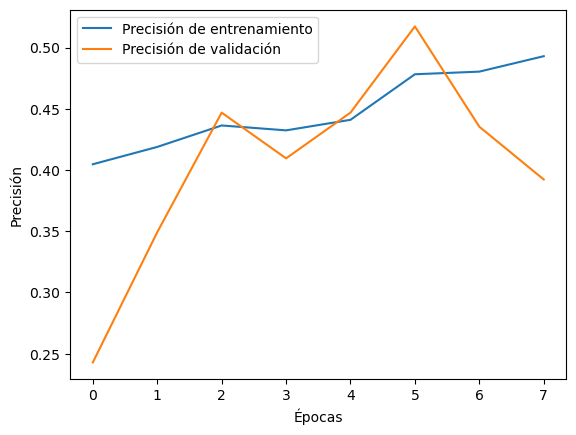

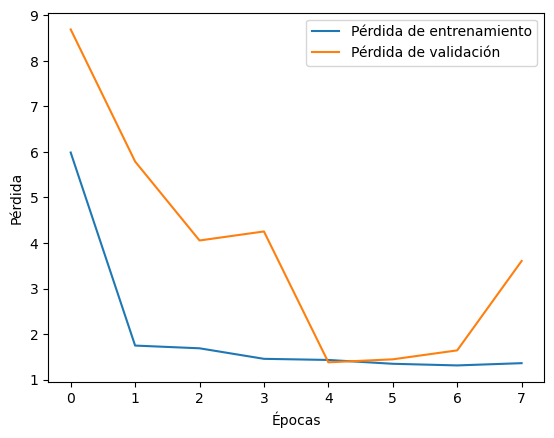

In [101]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [102]:
# Hacer predicciones en el conjunto de prueba
predictions = model_final.predict(test_dataset)

# Las predicciones son probabilidades, puedes convertirlas a clases
predicted_classes = (predictions > 0.5).astype(int) 

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step


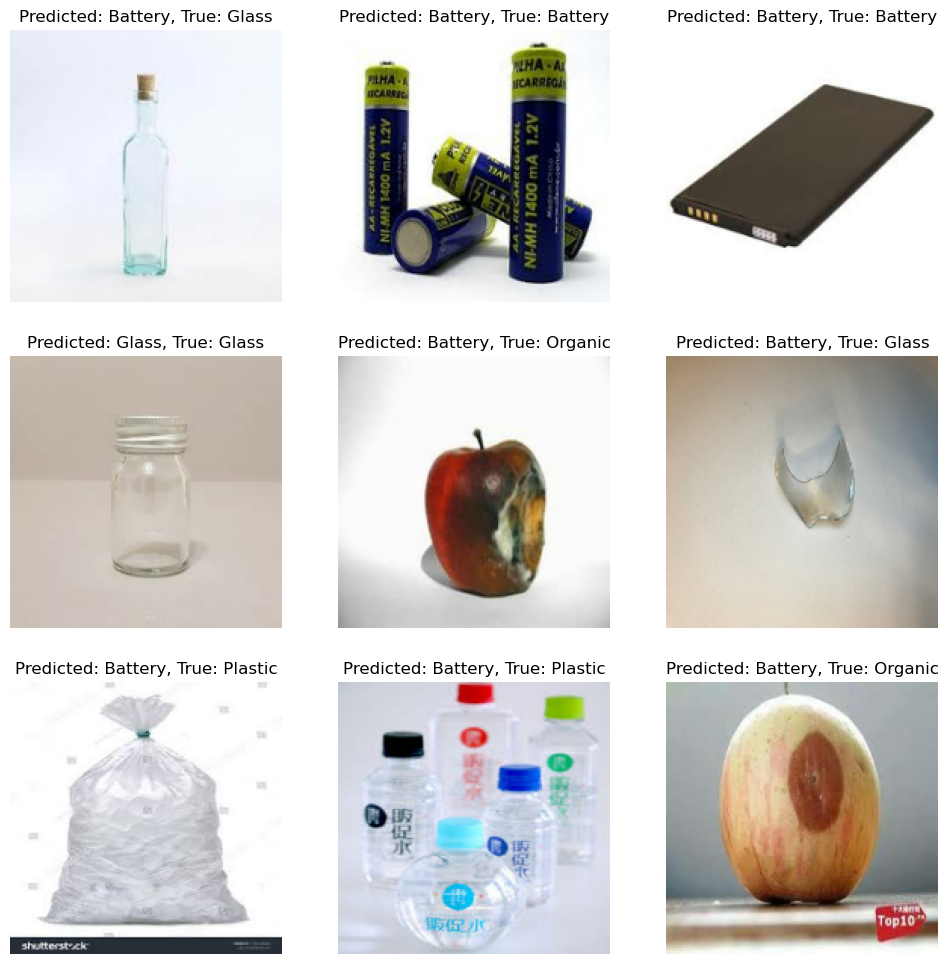

In [103]:
import matplotlib.pyplot as plt

# Función para visualizar imágenes y sus predicciones
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Predicted: {class_names[predicted_classes[i][0]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)


In [104]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.4575 - loss: 1.4315
Test Loss: 1.4944117069244385, Test Accuracy: 0.4316239356994629
